Importing Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extracting the MFCC Features from the audio Files

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import soundfile as sf
import librosa
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Set the path to the folder containing the audio files
data_folder = 'path of the dataset audio files'

# Set the desired number of MFCC coefficients and maximum sequence length
num_coefficients = 13
max_sequence_length = 1000

# Create empty lists to store the MFCC features and speaker labels
mfcc_features = []
speaker_labels = []

# Iterate through the audio files in the folder
for filename in os.listdir(data_folder):
    # Filename format: speakerID-index.flac
    if filename.endswith('.flac'):
        # Extract the speaker ID from the filename
        speaker_id = filename.split('-')[0]

        # Load the audio file
        audio, sr = sf.read(os.path.join(data_folder, filename))

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_coefficients)

        # Pad or truncate the MFCC features to the maximum sequence length
        if mfcc.shape[1] < max_sequence_length:
            pad_width = max_sequence_length - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)))
        else:
            mfcc = mfcc[:, :max_sequence_length]

        # Append the MFCC features and speaker label to the lists
        mfcc_features.append(mfcc)
        speaker_labels.append(speaker_id)

# Convert the lists to numpy arrays
mfcc_features = np.array(mfcc_features)
speaker_labels = np.array(speaker_labels)

# Split the data into training and testing sets
trainMFCC, testMFCC, trainSpeakerIDs, testSpeakerIDs = train_test_split(
    mfcc_features, speaker_labels, test_size=0.2, random_state=42)

# Reshape the input data
trainMFCC = trainMFCC[..., np.newaxis]
testMFCC = testMFCC[..., np.newaxis]

# Convert speaker IDs to numerical labels
unique_speakers = np.unique(speaker_labels)
num_speakers = len(unique_speakers)
label_to_id = {label: i for i, label in enumerate(unique_speakers)}
trainLabels = np.array([label_to_id[label] for label in trainSpeakerIDs])
testLabels = np.array([label_to_id[label] for label in testSpeakerIDs])

Applying KNN to the extracted MFCC Features

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Flatten the MFCC features
trainMFCC_flatten = trainMFCC.reshape(trainMFCC.shape[0], -1)
testMFCC_flatten = testMFCC.reshape(testMFCC.shape[0], -1)

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=len(unique_speakers))

# Fit the classifier on the training data
knn.fit(trainMFCC_flatten, trainLabels)

# Predict labels for the test data
predLabels = knn.predict(testMFCC_flatten)

# Compute accuracy
accuracy = accuracy_score(testLabels, predLabels)
print("Accuracy:", accuracy)


Accuracy: 0.22736418511066397


Applying Standard Scaling and KNN

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize the MFCC features
scaler = StandardScaler()
trainMFCC_normalized = scaler.fit_transform(trainMFCC_flatten)
testMFCC_normalized = scaler.transform(testMFCC_flatten)

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=4)

# Fit the classifier on the training data
knn.fit(trainMFCC_normalized, trainLabels)

# Predict labels for the test data
predLabels = knn.predict(testMFCC_normalized)

# Compute accuracy
accuracy = accuracy_score(testLabels, predLabels)
print("Accuracy:", accuracy)


Accuracy: 0.5372233400402414


Applying PCA and then KNN

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Flatten the MFCC features
trainMFCC_flatten = trainMFCC.reshape(trainMFCC.shape[0], -1)
testMFCC_flatten = testMFCC.reshape(testMFCC.shape[0], -1)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)  # Choose the desired number of components
trainMFCC_pca = pca.fit_transform(trainMFCC_flatten)
testMFCC_pca = pca.transform(testMFCC_flatten)

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier on the training data
knn.fit(trainMFCC_pca, trainLabels)

# Predict labels for the test data
predLabels = knn.predict(testMFCC_pca)

# Compute accuracy
accuracy = accuracy_score(testLabels, predLabels)
print("Accuracy:", accuracy)


Accuracy: 0.26156941649899396


Applying Scaling, SVD and KNN

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Normalize the MFCC features
scaler = StandardScaler()
trainMFCC_normalized = scaler.fit_transform(trainMFCC_flatten)
testMFCC_normalized = scaler.transform(testMFCC_flatten)

# Apply SVD for dimensionality reduction
svd = TruncatedSVD(n_components=20)  # Choose the desired number of components
trainMFCC_svd = svd.fit_transform(trainMFCC_normalized)
testMFCC_svd = svd.transform(testMFCC_normalized)

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=1)

# Fit the classifier on the training data
knn.fit(trainMFCC_svd, trainLabels)

# Predict labels for the test data
predLabels = knn.predict(testMFCC_svd)

# Compute accuracy
accuracy = accuracy_score(testLabels, predLabels)
print("Accuracy:", accuracy)


Accuracy: 0.9557344064386318


Classification Report and Confusion Matrix

Confusion Matrix:


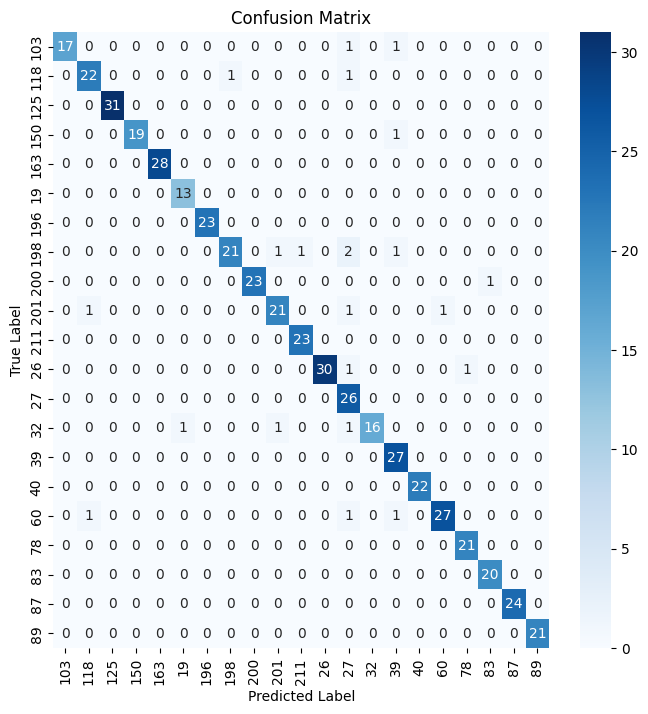


Classification Report:
              precision    recall  f1-score   support

         103       1.00      0.89      0.94        19
         118       0.92      0.92      0.92        24
         125       1.00      1.00      1.00        31
         150       1.00      0.95      0.97        20
         163       1.00      1.00      1.00        28
          19       0.93      1.00      0.96        13
         196       1.00      1.00      1.00        23
         198       0.95      0.81      0.88        26
         200       1.00      0.96      0.98        24
         201       0.91      0.88      0.89        24
         211       0.96      1.00      0.98        23
          26       1.00      0.94      0.97        32
          27       0.76      1.00      0.87        26
          32       1.00      0.84      0.91        19
          39       0.87      1.00      0.93        27
          40       1.00      1.00      1.00        22
          60       0.96      0.90      0.93        30
   

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(testLabels, predLabels)

# Calculate classification report
class_names = unique_speakers
report = classification_report(testLabels, predLabels, target_names=class_names)

print("Confusion Matrix:")
# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(report)

# Calculate accuracy
accuracy = accuracy_score(testLabels, predLabels)
print("Accuracy:", accuracy)
